In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp # for reference

import autograd.numpy as np
from neuralsolver import NNSolver

# Problem Definition

In [2]:
# process the initial value into a vector 
# to feed into odeint func (x0, y0, u0, v0)
def process_init_vector(obs1, obs2, t = 0.02):
    vector = np.array([ obs1[0], obs1[1], (obs2[0] - obs1[0])/t,  (obs2[1] - obs1[1])/t])
    return vector

# add noise because of uncertainty in the observations
# numpy.random.normal(loc=0.0, scale=1.0, size=None)
def add_noise(obs1, obs2):
    E_x = np.random.normal(loc = 0.0, scale = 0.002, size = 2)
    E_y = np.random.normal(loc = 0.0, scale = 0.002, size = 2)
    # here we have separate noise for each x and each y
    obs1_perturbed = np.array([obs1[0] + E_x[0], obs1[1] + E_y[0]])
    obs2_perturbed = np.array([obs2[0] + E_x[1], obs2[1] + E_y[1]])
    return obs1_perturbed, obs2_perturbed


In [3]:
# define ODE problem

earth_pos = np.array([0, 0])
moon_pos = np.array([1, 0])
R_earth = 0.02
R_moon = 0.005

obs1 = np.array([1.0798, 0])
obs2 = np.array([1.0802, -0.0189])

def f(t, vector):
    mu = 0.01
    x = vector[0]
    y = vector[1]
    u = vector[2]
    v = vector[3]
    #x, y, u, v = vector
    res = [u,\
            v,\
            v + x - mu - (x*(1 - mu))/((x**2 + y**2)**1.5) - (mu*(x - 1))/(((x - 1)**2 + y**2)**1.5),\
            (-u + y - ((1-mu)*y)/((x**2 + y**2)**1.5) - (mu*y)/(((x - 1)**2 + y**2)**1.5))]
    return res

t = np.linspace(0, 10, 2000).reshape(-1, 1) #increase training points
obs1_perturbed, obs2_perturbed = add_noise(obs1, obs2)
y0_list = process_init_vector(obs1_perturbed, obs2_perturbed) # for one single

# Reference solution

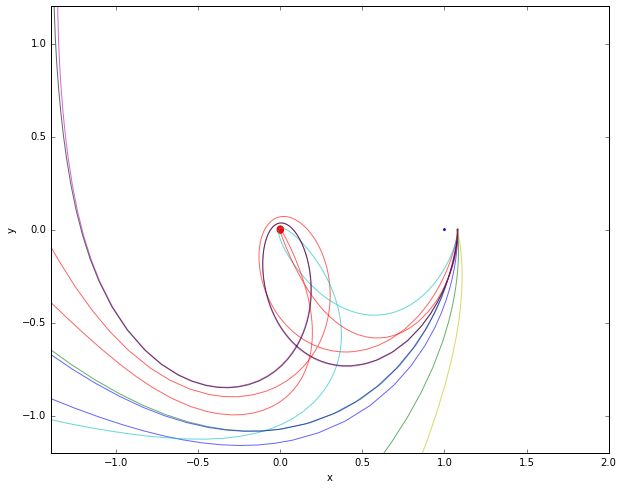

In [4]:
#plt.grid('off')
plt.figure(figsize=(10, 8))

# such that the size is proportional to the radius given
fig = plt.gcf()
circle_earth =plt.Circle(earth_pos, R_earth, color='red')
circle_moon =plt.Circle(moon_pos, R_moon, color='blue')
fig.gca().add_artist(circle_earth)
fig.gca().add_artist(circle_moon)
plt.xlim(-1.4, 2)
plt.ylim(-1.2, 1.2)

#plt.scatter(earth_pos[0], earth_pos[1], s= 100, label = "earth")
#plt.scatter(moon_pos[0], moon_pos[1], s= 80, color = 'red', label = "moon")
plt.xlabel('x')
plt.ylabel('y')
#plt.legend()

for i in range(10):
    obs1_perturbed, obs2_perturbed = add_noise(obs1, obs2)
    y0_list = process_init_vector(obs1_perturbed, obs2_perturbed)
    sol = solve_ivp(f, [t.min(), t.max()], y0_list, 
                method='Radau', rtol=1e-5)
    plt.plot(sol.y[0], sol.y[1], alpha = 0.6)
    

# Neural Net Training

In [5]:
nn = NNSolver(f, t, y0_list, n_hidden=20)
nn

Neural ODE Solver 
Number of equations:       4 
Initial condition y0:      [ 1.07884956 -0.00217751  0.08419515 -0.7406873 ] 
Numnber of hidden units:   20 
Number of training points: 2000 

In [6]:
nn.reset_weights()
%time nn.train(maxiter=500, iprint=100)

iteration: 0 loss:  916.033493516
iteration: 100 loss:  0.00226692708823
iteration: 200 loss:  0.00156107279454
iteration: 300 loss:  0.00117794549256
iteration: 400 loss:  0.00103820765089
         Current function value: 0.000853
         Iterations: 500
         Function evaluations: 540
         Gradient evaluations: 540
CPU times: user 35.3 s, sys: 2.21 s, total: 37.6 s
Wall time: 37.2 s


# Verifying training set

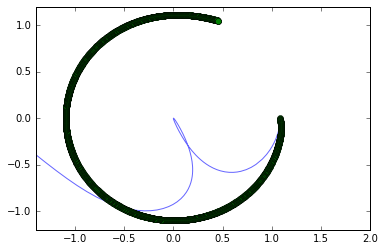

In [8]:
# using the y0 from the last iteration in for loop
plt.xlim(-1.4, 2)
plt.ylim(-1.2, 1.2)
plt.plot(sol.y[0], sol.y[1], alpha = 0.6, label = 'true')
y_pred_list, dydt_pred_list = nn.predict()
plt.plot(y_pred_list[0], y_pred_list[1], 'o', label = 'predict')

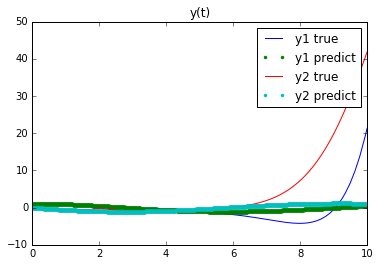

In [9]:
y_pred_list, dydt_pred_list = nn.predict()
# scipy sol
plt.plot(sol.t, sol.y[0], label='y1 true')
# nn soln
plt.plot(t, y_pred_list[0], '.', label='y1 predict')

plt.plot(sol.t, sol.y[1], label='y2 true')
plt.plot(t, y_pred_list[1], '.', label='y2 predict')

plt.legend()
plt.title('y(t)')